## Model Fine-tuning and Optimization

In [ ]:
# Imports
import os
import re
import pandas as pd
import numpy as np
from functions import *

import torch
import gc
import pickle
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, Trainer, TrainingArguments
import bitsandbytes as bnb
from datasets import Dataset

# Load data
data = '../data/ready_for_phi-2/'

print(os.path.exists(data))
print(os.listdir(data))

from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
import evaluate

#### Loading

In [34]:
# Load
train10k = pd.read_csv(data + 'train_01.csv')
train5k = pd.read_csv(data + 'train_02.csv')

test2k = pd.read_csv(data + 'test_01.csv')
test1k = pd.read_csv(data + 'test_02.csv')

train10k_benchmark = pd.read_csv(data + 'eval/' + 'train10k_sample.csv')

# ===================== #
# Selecting only the columns we need for fine-tuning
# ===================== #

# 15k training samples
train10k = train10k[['label', 'prompt', 'response']]
train5k = train5k[['label', 'prompt', 'response']]

# 3k test samples
test2k = test2k[['label', 'prompt', 'response']]
test1k = test1k[['label', 'prompt', 'response']]

# Rename columns
train10k.columns = ['label', 'input', 'mistral_output']
train5k.columns = ['label', 'input', 'mistral_output']
test2k.columns = ['label', 'input', 'mistral_output']
test1k.columns = ['label', 'input', 'mistral_output']

train10k.shape, train5k.shape, test2k.shape, test1k.shape

((9999, 3), (4998, 3), (1998, 3), (999, 3))

In [4]:
train10k.columns

Index(['label', 'input', 'mistral_output'], dtype='object')

In [5]:
dfs = [train10k, train5k, test2k, test1k]

for df in dfs:
  df['mistral_output'] = df.apply(lambda row: clean_output(row['input'], row['mistral_output']), axis=1)

In [6]:
for df in dfs:
  df['input'] = df['input'].str.replace('[INST]', '')
  df['input'] = df['input'].str.replace('[/INST]', '')

In [7]:
train10k.head()

,label,input,mistral_output
0,2,A customer left us a 2-star review: 'the cash...,A customer left us a 2-star review: 'the cashi...
1,2,A customer left us a 2-star review: 'here's w...,A customer left us a 2-star review: 'here's wh...
2,2,A customer left us a 2-star review: 'went to ...,A customer left us a 2-star review: 'went to t...
3,2,A customer left us a 2-star review: 'went to ...,A customer left us a 2-star review: 'went to c...
4,2,A customer left us a 2-star review: 'a whole ...,A customer left us a 2-star review: 'a whole l...


In [8]:
# Saving
fine_tuning_data = '../data/for_step_4/'

if not os.path.exists(fine_tuning_data):
  os.makedirs(fine_tuning_data)

In [9]:
train10k.to_csv(fine_tuning_data + 'train10k.csv', index=False)
train5k.to_csv(fine_tuning_data + 'train5k.csv', index=False)
test2k.to_csv(fine_tuning_data + 'test2k.csv', index=False)
test1k.to_csv(fine_tuning_data + 'test1k.csv', index=False)

if fine_tuning_data + 'train10k.csv':
  print('File 1 saved successfully!')
if fine_tuning_data + 'train5k.csv':
  print('File 2 saved successfully!')
if fine_tuning_data + 'test2k.csv':
  print('File 3 saved successfully!')
if fine_tuning_data + 'test1k.csv':
  print('File 4 saved successfully!')

File 1 saved successfully!
File 2 saved successfully!
File 3 saved successfully!
File 4 saved successfully!


### Model

In [ ]:
# Define 4-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

# Load model and tokenizer
model_name = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = 'right'

model = AutoModelForCausalLM.from_pretrained(model_name,
                                             quantization_config=bnb_config,
                                             device_map={"": 0})

# Prepare model for kbit training
model = prepare_model_for_kbit_training(model)

# Define LoRA configuration
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    # Target the attention modules in Phi-2
    target_modules=["q_proj", 
                    "k_proj", 
                    "v_proj", 
                    "out_proj",
                    "fc1",
                    "fc2"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA
model = get_peft_model(model, lora_config)

# Get model device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"==========\n! Model loaded on: {device}\n")
# print(model.quantization_method)
# print(model.config)

model.config.use_cache = False
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

model.train()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

! Model loaded on: cuda



PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2560, out_features=2560, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2560, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDic

In [3]:
gc.collect()
torch.cuda.empty_cache()

# Print GPU memory usage
print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e6:.2f} MB")
print(f"GPU memory cached: {torch.cuda.memory_reserved()/1e6:.2f} MB")

GPU memory allocated: 2392.86 MB
GPU memory cached: 2472.54 MB


In [4]:
# for name, _ in model.named_modules():
#   print(name)

In [5]:
if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token

In [6]:
def train_tokenize_function(df):
    combined = []
    for i in range(len(df["input"])):
        combined.append(
            "Instruction: " + df["input"][i] + "\nResponse: " + df["mistral_output"][i]
        )
    
    # Tokenize sequences
    tokenized = tokenizer(
        combined,
        max_length=2048,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    
    labels = tokenized["input_ids"].clone()
   
    # Mask out the loss for the instruction part
    for i in range(len(combined)):
        instruction = "Instruction: " + df["input"][i] + "\nResponse: "
        instruction_tokens = tokenizer(instruction, return_tensors="pt")["input_ids"][0]
        instruction_length = len(instruction_tokens)
       
        # Set labels to -100 for the instruction part (no loss computed)
        labels[i, :instruction_length] = -100
   
    return {
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],
        "labels": labels
    }

In [7]:
def test_tokenize_function(df):
    # Tokenize the prompt (input)
    tokenized_inputs = tokenizer(
        df["input"],
        max_length=2048,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    
    # Tokenize the gold responses (mistral_output)
    tokenized_gold = tokenizer(
        df["mistral_output"],
        max_length=2048,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )
    
    # Use the gold tokenized outputs as labels for metric computation
    tokenized_inputs["labels"] = tokenized_gold["input_ids"]
    
    return tokenized_inputs

In [ ]:
# Saving
fine_tuning_data = '../data/for_step_4/'

# Load
train10k = pd.read_csv(fine_tuning_data + 'train10k.csv')
#train5k = pd.read_csv(fine_tuning_data + 'train5k.csv')
test2k = pd.read_csv(fine_tuning_data + 'test2k.csv')
#test1k = pd.read_csv(fine_tuning_data + 'test1k.csv')


# Time constraints. I'll just use 999 train, 333 test samples
from sklearn.model_selection import train_test_split
train_left, train = train_test_split(train10k, 
                         test_size=999, 
                         random_state=42,
                         stratify=train10k['label'])
train_left, test = train_test_split(test2k, 
                        test_size=333, 
                        random_state=42,
                        stratify=test2k['label'])

# train.shape, test.shape, train['label'].value_counts(), test['label'].value_counts()

# Selecting only the columns we need for fine-tuning, I was splitting by label.
train = train[['input', 'mistral_output']]
test = test[['input', 'mistral_output']]

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train)
train_dataset = train_dataset.remove_columns(['__index_level_0__'])

test_dataset = Dataset.from_pandas(test)
test_dataset = test_dataset.remove_columns(['__index_level_0__'])

# Tokenize
tokenized_train_dataset = train_dataset.map(train_tokenize_function,
                                            batched=True)
tokenized_test_dataset = test_dataset.map(test_tokenize_function,
                                          batched=True)

"# Convert to HuggingFace Datasets\ntrain_dataset = Dataset.from_pandas(train)\ntrain_dataset = train_dataset.remove_columns(['__index_level_0__'])\n\ntest_dataset = Dataset.from_pandas(test)\ntest_dataset = test_dataset.remove_columns(['__index_level_0__'])\n\n# Tokenize\ntokenized_train_dataset = train_dataset.map(train_tokenize_function,\n                                            batched=True)\ntokenized_test_dataset = test_dataset.map(test_tokenize_function,\n                                          batched=True)"

In [9]:
"""
# Selecting only the columns we need for fine-tuning, I was splitting by label.
train10k = train10k[['input', 'mistral_output']]
train5k = train5k[['input', 'mistral_output']]
test2k = test2k[['input']]
test1k = test1k[['input']]

# Convert to HuggingFace Datasets
from datasets import Dataset

train = Dataset.from_pandas(train)
test = Dataset.from_pandas(test)

train10k_dataset = Dataset.from_pandas(train10k)
train5k_dataset = Dataset.from_pandas(train5k)
test2k_dataset = Dataset.from_pandas(test2k)
test1k_dataset = Dataset.from_pandas(test1k)

# Tokenize
train = train.map(train_tokenize_function,
                  batched=True)
test = test.map(test_tokenize_function, 
                  batched=True)
"""

"\n# Selecting only the columns we need for fine-tuning, I was splitting by label.\ntrain10k = train10k[['input', 'mistral_output']]\ntrain5k = train5k[['input', 'mistral_output']]\ntest2k = test2k[['input']]\ntest1k = test1k[['input']]\n\n# Convert to HuggingFace Datasets\nfrom datasets import Dataset\n\ntrain = Dataset.from_pandas(train)\ntest = Dataset.from_pandas(test)\n\ntrain10k_dataset = Dataset.from_pandas(train10k)\ntrain5k_dataset = Dataset.from_pandas(train5k)\ntest2k_dataset = Dataset.from_pandas(test2k)\ntest1k_dataset = Dataset.from_pandas(test1k)\n\n# Tokenize\ntrain = train.map(train_tokenize_function,\n                  batched=True)\ntest = test.map(test_tokenize_function, \n                  batched=True)\n"

In [10]:
# train_dataset, test_dataset

In [11]:
# tokenized_train_dataset, tokenized_test_dataset

In [12]:
#print(tokenizer.decode(tokenized_train_dataset['input_ids'][0]))
#print('\n\n')

#print(tokenizer.decode(tokenized_test_dataset['input_ids'][0]))
#print(tokenizer.decode(tokenized_test_dataset['labels'][0]))

In [13]:
# Model output
model_path = '../models/'

if not os.path.exists(model_path):
  os.makedirs(model_path)

#### Evaluate

In [14]:
import logging
import evaluate

# Load evaluation metrics
bleurt = evaluate.load("bleurt", trust_remote_code=True)
bertscore = evaluate.load("bertscore")
meteor = evaluate.load("meteor")

def compute_metrics(eval_preds):
    """
    Computes BLEURT, BERTScore (F1), and METEOR for evaluating generated feedback.

    Args:
        eval_preds (tuple): A tuple containing (predictions, references).

    Returns:
        dict: A dictionary with metric scores.
    """
    predictions, references = eval_preds

    # Ensure string format
    predictions = [str(pred).strip() for pred in predictions]
    references = [str(ref).strip() for ref in references]

    # Compute BLEURT
    bleurt_scores = bleurt.compute(predictions=predictions, references=references)["scores"]

    # Compute BERTScore(F1)
    bertscore_f1 = bertscore.compute(predictions=predictions, references=references, lang="en")["f1"]

    # Compute METEOR
    meteor_score = meteor.compute(predictions=predictions, references=references)["meteor"]

    metrics = {
        "bleurt": np.mean(bleurt_scores),
        "bertscore_f1": np.mean(bertscore_f1),
        "meteor": meteor_score
    }

    logger.info(f"Eval Metrics: {metrics}")  # Force logging

    return metrics

Using default BLEURT-Base checkpoint for sequence maximum length 128. You can use a bigger model for better results with e.g.: evaluate.load('bleurt', 'bleurt-large-512').


INFO:tensorflow:Reading checkpoint C:\Users\kadm2\.cache\huggingface\metrics\bleurt\default\downloads\extracted\1ed47b7280a9b4162e745e8e509d21a5ca48976269d7d45c0c7b6c6e350c760e\bleurt-base-128.
INFO:tensorflow:Config file found, reading.
INFO:tensorflow:Will load checkpoint bert_custom
INFO:tensorflow:Loads full paths and checks that files exists.
INFO:tensorflow:... name:bert_custom
INFO:tensorflow:... vocab_file:vocab.txt
INFO:tensorflow:... bert_config_file:bert_config.json
INFO:tensorflow:... do_lower_case:True
INFO:tensorflow:... max_seq_length:128
INFO:tensorflow:Creating BLEURT scorer.
INFO:tensorflow:Creating WordPiece tokenizer.
INFO:tensorflow:WordPiece tokenizer instantiated.
INFO:tensorflow:Creating Eager Mode predictor.
INFO:tensorflow:Loading model.
INFO:tensorflow:BLEURT initialized.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kadm2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kadm2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kadm2\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Training

In [18]:
gc.collect()
torch.cuda.empty_cache()
from transformers import EarlyStoppingCallback

In [29]:
training_args = TrainingArguments(
  output_dir=model_path,
  do_train=True,
  do_eval=True,
  do_predict=True,
  
  eval_strategy="steps",\
  eval_steps=150,
  save_strategy="steps",
  save_steps=150,
  eval_accumulation_steps=8,
  logging_strategy="epoch",
  num_train_epochs=3,
  
  learning_rate=2e-5,
  lr_scheduler_type="cosine",
  warmup_ratio=0.1,
  weight_decay=0.01,
  
  fp16=True,
  dataloader_num_workers=4,
  
  optim="adamw_torch_fused",
  load_best_model_at_end=True,
  metric_for_best_model="loss", # It was meteor, but GPU can't handle the custom eval.
  greater_is_better=False,
  
  report_to="tensorboard",
  resume_from_checkpoint=True,
  
  per_device_eval_batch_size=4,
  per_device_train_batch_size=4,
  gradient_accumulation_steps=4,
  gradient_checkpointing=True,
  save_total_limit=4
)

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] 
    # compute_metrics=compute_metrics, # OOMs
)

trainer.train()
trainer.save_model(os.path.join(model_path, 'phi-2_01'))

  0%|          | 0/186 [00:00<?, ?it/s]

{'loss': 0.0565, 'grad_norm': 0.09207917749881744, 'learning_rate': 1.6902852688348866e-05, 'epoch': 0.99}
{'loss': 0.0539, 'grad_norm': 0.09972906112670898, 'learning_rate': 5.892573252966926e-06, 'epoch': 2.0}


  0%|          | 0/84 [00:00<?, ?it/s]

{'eval_loss': 2.874305009841919, 'eval_runtime': 359.5017, 'eval_samples_per_second': 0.926, 'eval_steps_per_second': 0.234, 'epoch': 2.4}
{'loss': 0.0535, 'grad_norm': 0.08853914588689804, 'learning_rate': 0.0, 'epoch': 2.98}
{'train_runtime': 11880.4382, 'train_samples_per_second': 0.252, 'train_steps_per_second': 0.016, 'train_loss': 0.054654449544927125, 'epoch': 2.98}


In [17]:
gc.collect()
torch.cuda.empty_cache()

## Fine-tuned Model

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch

base_model_name = "microsoft/phi-2"  # Your original model
adapter_path = "../models/phi-2_01"

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(base_model_name, torch_dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

# Load LoRA adapter and merge
model = PeftModel.from_pretrained(base_model, adapter_path)
model = model.merge_and_unload()  # Merge LoRA with base model

# Move to GPU if available
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((256

In [ ]:
merged_model_path = "../models/phi-2_full_2"
model.save_pretrained(merged_model_path)
tokenizer.save_pretrained(merged_model_path)

In [225]:
gc.collect()
torch.cuda.empty_cache()

### Loading merged version

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

merged_model_path = "../models/phi-2_full_2"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(merged_model_path)
tokenizer.padding_side = 'left'

# Load the model
model = AutoModelForCausalLM.from_pretrained(
    merged_model_path,
    torch_dtype=torch.float16,
    device_map="auto",
    offload_buffers=True
)

# Get model device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"==========\n! Model loaded on: {device}\n")
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


! Model loaded on: cuda



PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((256

In [ ]:
prompt = "A customer left us a 2-star review: 'here's what happened n we were suppose to be at the regular mgm.. so we pulled up, put our car in valet, got a bell boy to take our stuff.. and then we realized they gave us rooms at the signature. what a pain!!!! n then when we tried to check in we were suppose to have 2 rooms... but they couldn't find our other reservation because we booked through an online travel company so they only gave us one room!!! n the next day we had to spend at least an hour trying to get compensated for the room that we pre paid for! finally they gave us back the money and also said they would give us 200 to spend on food and bev. n so, we ordered 158 in food that night... and tipped 30! n then when i went to check out... they had all the room service charges and all the room charges on my card!!! it was such a hassle to get them off!!! in the end, they took off all charges but the 30 tip which i was still mad about. n nthe rooms were super nice! they had a nice kitchen and a nice view. but, i do not consider it much of an upgrade from the mgm since one of the beds is a pull out couch. n nalso, we were there for a bachelorette party... and the bachelorette likes to gamble.. so it probably would have been more ideal to stay in the casino. n noverall, the condo was very nice... but the customer service was totally disorganized and bad. numerous times the signature blamed their poor service on the mgm and said they couldn't do anything about our problems since we booked through the mgm.' The customer feels realization, neutral, disappointment. Concisely, how can we best improve our services for this customer's experience? \n\nResponse: "
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

with torch.no_grad():
    output = model.generate(**inputs, 
                            max_new_tokens=1000,
                            no_repeat_ngram_size=3,
                            do_sample=True,
                            pad_token_id=tokenizer.eos_token_id,
                            temperature=0.2,
                            top_p=0.9,
                            top_k=50) 

output = tokenizer.decode(output[0], skip_special_tokens=True)
print(clean_phi2_output(prompt, output))

1. Improve Communication: Ensure that all staff members are well-trained in communicating with customers, especially when it comes to explaining the booking process and any potential issues that may arise. This will help prevent misunderstandings and frustration.


> Close enough to mistral's output.

In [ ]:
print(tokenizer.encode(prompt))
print(tokenizer.decode(tokenizer.encode(prompt)))

[317, 6491, 1364, 514, 257, 362, 12, 7364, 2423, 25, 705, 1456, 338, 644, 3022, 299, 356, 547, 11691, 284, 307, 379, 262, 3218, 10527, 76, 492, 523, 356, 5954, 510, 11, 1234, 674, 1097, 287, 1188, 316, 11, 1392, 257, 8966, 2933, 284, 1011, 674, 3404, 492, 290, 788, 356, 6939, 484, 2921, 514, 9519, 379, 262, 9877, 13, 644, 257, 2356, 13896, 299, 788, 618, 356, 3088, 284, 2198, 287, 356, 547, 11691, 284, 423, 362, 9519, 986, 475, 484, 3521, 470, 1064, 674, 584, 24048, 780, 356, 21765, 832, 281, 2691, 3067, 1664, 523, 484, 691, 2921, 514, 530, 2119, 10185, 299, 262, 1306, 1110, 356, 550, 284, 4341, 379, 1551, 281, 1711, 2111, 284, 651, 34304, 329, 262, 2119, 326, 356, 662, 3432, 329, 0, 3443, 484, 2921, 514, 736, 262, 1637, 290, 635, 531, 484, 561, 1577, 514, 939, 284, 4341, 319, 2057, 290, 307, 85, 13, 299, 523, 11, 356, 6149, 24063, 287, 2057, 326, 1755, 986, 290, 28395, 1542, 0, 299, 788, 618, 1312, 1816, 284, 2198, 503, 986, 484, 550, 477, 262, 2119, 2139, 4530, 290, 477, 262, 2119, 4

### Generate

In [3]:
gc.collect()
torch.cuda.empty_cache()

In [4]:
# Load benchmark, model *may* have seen parts of this benchmark during training. It's a sample of the training data. It's ok for now.
train10k_benchmark = pd.read_csv('../data/ready_for_phi-2/eval/train10k_sample.csv')

train10k_benchmark.shape, train10k_benchmark.columns

((1000, 4),
 Index(['label', 'input', 'mistral_output', 'phi-2_output'], dtype='object'))

In [26]:
train10k_benchmark.head()

,label,input,mistral_output,phi-2_output
0,1,A customer left us a 1-star review: 'i had the...,"To improve the customer's experience, we can t...",A customer left us a 1-star review: 'i had the...
1,3,A customer left us a 3-star review: 'i've been...,"To improve the customer's experience, consider...",The customer's experience is a combination of ...
2,3,A customer left us a 3-star review: 'a problem...,"To improve the customer's experience, consider...",The customer's experience is a complex and dyn...
3,1,A customer left us a 1-star review: 'i'd never...,"To improve the customer's experience, we can f...","In the world of customer service, it is import..."
4,2,A customer left us a 2-star review: 'oh rue 21...,"To improve the customer's experience at Rue21,...",A: I think you can use this: $str = ''' a cust...


In [ ]:
# Function to generate feedback
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    
# Define function to generate responses
def generate_response(prompts, batch_size=8, checkpoint_path='inference_checkpoint.pkl'):
    all_responses = [""] * len(prompts)  # Pre-allocate list
    start_batch = 0
    prompts = list(prompts)

    # Load checkpoint if it exists
    if os.path.exists(checkpoint_path):
        try:
            with open(checkpoint_path, 'rb') as f:
                checkpoint = pickle.load(f)
                all_responses = checkpoint['responses']
                start_batch = checkpoint['next_batch']
                print(f"Resuming from checkpoint: {start_batch * batch_size}/{len(prompts)} items processed")
        except Exception as e:
            print(f"Error loading checkpoint: {e}. Starting fresh...")
            all_responses = [""] * len(prompts)
            start_batch = 0

    try:
        for i in tqdm(range(start_batch * batch_size, len(prompts), batch_size), desc="Processing batches"):
            batch_prompts = prompts[i:i+batch_size]
            batch_idx = i // batch_size  # Track batch number

            try:
                inputs = tokenizer(batch_prompts, 
                                   padding=True, 
                                   truncation=True, 
                                   max_length=512, 
                                   return_tensors="pt").to(device)

                with torch.no_grad():
                    outputs = model.generate(**inputs, 
                                             max_new_tokens=500,
                                             no_repeat_ngram_size=3,
                                             do_sample=True,
                                             pad_token_id=tokenizer.eos_token_id,
                                             temperature=0.5,
                                             top_p=0.9,
                                             top_k=50
                                             )

                batch_responses = []
                for j in range(len(outputs)):
                    try:
                        full_text = tokenizer.decode(outputs[j], skip_special_tokens=True)
                        prompt_text = tokenizer.decode(inputs['input_ids'][j], skip_special_tokens=True)
                        
                        response = full_text.replace(prompt_text, "", 1).strip()
                        response = clean_response(response)
                    except Exception as e:
                        response = "ERROR_GENERATING_RESPONSE"
                        print(f"Error: {e}")
                        
                    batch_responses.append(response)

                # Assign responses to correct indices
                all_responses[i:i+batch_size] = batch_responses

                # Save progress to checkpoint (AFTER a batch is completed)
                checkpoint = {'responses': all_responses, 'next_batch': batch_idx + 1}
                with open(checkpoint_path, 'wb') as f:
                    pickle.dump(checkpoint, f)

                # Free GPU memory
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    gc.collect()

            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                
                # Assign error responses only to the failed batch
                all_responses[i:i+batch_size] = ["ERROR_GENERATING_RESPONSE"] * len(batch_prompts)

                # Save progress to checkpoint even if batch fails
                checkpoint = {'responses': all_responses, 'next_batch': batch_idx + 1}
                with open(checkpoint_path, 'wb') as f:
                    pickle.dump(checkpoint, f)

    except KeyboardInterrupt:
        print("\nProcess interrupted. Saving progress...")
        with open(checkpoint_path, 'wb') as f:
            pickle.dump({'responses': all_responses, 'next_batch': i // batch_size + 1}, f)

    # Fill any missing responses
    if "" in all_responses:
        all_responses = ["ERROR_GENERATING_RESPONSE" if r == "" else r for r in all_responses]

    # Remove checkpoint if processing completes successfully
    if len(all_responses) == len(prompts) and os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)
        print("Processing completed, checkpoint removed.")

    return all_responses

In [7]:
# The instructions are differently stuctured during training:
train10k_benchmark['phi_input'] = train10k_benchmark.apply(lambda row: row['input'] + '\nResponse: ', axis=1)

train10k_benchmark.head()

,label,input,mistral_output,phi-2_output,phi_input
0,1,A customer left us a 1-star review: 'i had the...,"To improve the customer's experience, we can t...",A customer left us a 1-star review: 'i had the...,Instruction: A customer left us a 1-star revie...
1,3,A customer left us a 3-star review: 'i've been...,"To improve the customer's experience, consider...",The customer's experience is a combination of ...,Instruction: A customer left us a 3-star revie...
2,3,A customer left us a 3-star review: 'a problem...,"To improve the customer's experience, consider...",The customer's experience is a complex and dyn...,Instruction: A customer left us a 3-star revie...
3,1,A customer left us a 1-star review: 'i'd never...,"To improve the customer's experience, we can f...","In the world of customer service, it is import...",Instruction: A customer left us a 1-star revie...
4,2,A customer left us a 2-star review: 'oh rue 21...,"To improve the customer's experience at Rue21,...",A: I think you can use this: $str = ''' a cust...,Instruction: A customer left us a 2-star revie...


In [ ]:
train10k_benchmark.drop(columns=['phi-2_output_fine-tuned'], inplace=True)

In [9]:
train10k_benchmark['phi-2_output_fine-tuned'] = generate_response(train10k_benchmark['phi_input'], batch_size=5)

Processing batches:   0%|          | 0/200 [00:00<?, ?it/s]

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Processing completed, checkpoint removed.


In [58]:
train10k_benchmark.head()

,input,phi-2_output_final
0,A customer left us a 1-star review: 'i had the...,1. Apologize for the poor experience: Acknowle...
1,A customer left us a 3-star review: 'i've been...,1. Verify Age: Implement a more stringent age ...
2,A customer left us a 3-star review: 'a problem...,1. Emphasize the importance of cash tips: High...
3,A customer left us a 1-star review: 'i'd never...,1. Improve Communication: Ensure that the deli...
4,A customer left us a 2-star review: 'oh rue 21...,1. Improve product quality: Ensure that the cl...


In [81]:
train10k_benchmark.to_csv('../data/ready_for_phi-2/eval/train10k_sample_fine-tuned.csv', index=False)

## Evaluate

In [83]:
# Load
train10k_benchmark = pd.read_csv('../data/ready_for_phi-2/eval/train10k_sample_fine-tuned.csv')

train10k_benchmark.shape, train10k_benchmark.columns

((1000, 6),
 Index(['label', 'input', 'mistral_output', 'phi-2_output', 'phi_input',
        'phi-2_output_fine-tuned'],
       dtype='object'))

In [85]:
# rename column
train10k_benchmark.columns = ['label', 'input', 'mistral_output', 'phi-2_output_base_model', 'phi_input', 'phi-2_output_fine-tuned']

train10k_benchmark.columns

Index(['label', 'input', 'mistral_output', 'phi-2_output_base_model',
       'phi_input', 'phi-2_output_fine-tuned'],
      dtype='object')

In [87]:
# Load evaluation metrics
bleurt = evaluate.load("bleurt", trust_remote_code=True)
bertscore = evaluate.load("bertscore")
meteor = evaluate.load("meteor")

# Compute BLEURT scores
bleurt_scores = bleurt.compute(predictions=train10k_benchmark['phi-2_output_fine-tuned'],
                              references=train10k_benchmark['mistral_output'])

# Extract inputs and outputs
mistral_outputs = train10k_benchmark["mistral_output"].tolist()  # Ground truth
fine_phi2_outputs = train10k_benchmark['phi-2_output_fine-tuned'].tolist()  # Model to evaluate

# Compute BERTScore
bertscore_results = bertscore.compute(predictions=fine_phi2_outputs, 
                                      references=mistral_outputs, 
                                      lang="en")
bertscore_scores = bertscore_results["f1"]

# Compute METEOR
meteor_scores = meteor.compute(predictions=fine_phi2_outputs,
                               references=mistral_outputs)["meteor"]

# Aggregate Results
results_df = pd.DataFrame({
    "bleurt": (bleurt_scores["scores"]),
    "bertscore": bertscore_scores,
    "meteor": meteor_scores
})

results_df = results_df.round(4)
results_df.describe()

Using default BLEURT-Base checkpoint for sequence maximum length 128. You can use a bigger model for better results with e.g.: evaluate.load('bleurt', 'bleurt-large-512').


INFO:tensorflow:Reading checkpoint C:\Users\kadm2\.cache\huggingface\metrics\bleurt\default\downloads\extracted\1ed47b7280a9b4162e745e8e509d21a5ca48976269d7d45c0c7b6c6e350c760e\bleurt-base-128.
INFO:tensorflow:Config file found, reading.
INFO:tensorflow:Will load checkpoint bert_custom
INFO:tensorflow:Loads full paths and checks that files exists.
INFO:tensorflow:... name:bert_custom
INFO:tensorflow:... vocab_file:vocab.txt
INFO:tensorflow:... bert_config_file:bert_config.json
INFO:tensorflow:... do_lower_case:True
INFO:tensorflow:... max_seq_length:128
INFO:tensorflow:Creating BLEURT scorer.
INFO:tensorflow:Creating WordPiece tokenizer.
INFO:tensorflow:WordPiece tokenizer instantiated.
INFO:tensorflow:Creating Eager Mode predictor.
INFO:tensorflow:Loading model.
INFO:tensorflow:BLEURT initialized.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kadm2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kadm2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kadm2\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,bleurt,bertscore,meteor
count,1000.000000,1000.000000,1.000000e+03
mean,-0.376466,0.885482,2.318000e-01
std,0.286724,0.016650,1.444012e-15
min,-1.858700,0.790600,2.318000e-01
25%,-0.548975,0.876675,2.318000e-01
50%,-0.338350,0.887300,2.318000e-01
75%,-0.159225,0.897000,2.318000e-01
max,0.216300,0.928200,2.318000e-01


In [88]:
# Compute Mean & Median Scores
summary = results_df.agg(["mean", "median"])
print(summary.to_markdown())

|        |    bleurt |   bertscore |   meteor |
|:-------|----------:|------------:|---------:|
| mean   | -0.376466 |    0.885482 |   0.2318 |
| median | -0.33835  |    0.8873   |   0.2318 |


#### Visualize

In [7]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Save img
img_path = '../images'
if not os.path.exists(img_path):
    os.makedirs(img_path)

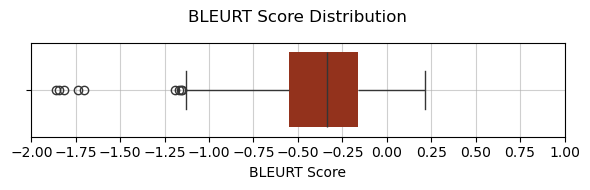

In [43]:
# Boxplot: BLEURT Score Distribution
plt.figure(figsize=(6, 2))

sns.boxplot(x=results_df['bleurt'], 
            color="#A72608",
            legend=False,
            boxprops={'edgecolor': 'none'})

plt.title("BLEURT Score Distribution",
          fontsize=12,
          fontweight='medium',
          pad=15)
plt.xlabel("BLEURT Score")
plt.xticks(np.arange(-2.0, 1.01, 0.25))
plt.grid(True, 
         alpha=0.6)

plt.tight_layout()
plt.savefig(img_path + '/fine-tuned_bleurt_score_distribution.png')
plt.show()

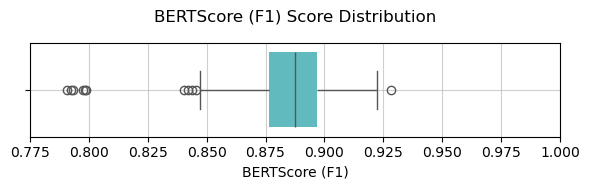

In [42]:
# Boxplot: BERTScore (F1) Score Distribution
plt.figure(figsize=(6, 2))

sns.boxplot(x=results_df['bertscore'], 
            color="#50C9CE",
            legend=False,
            boxprops={'edgecolor': 'none'})

plt.title("BERTScore (F1) Score Distribution",
          fontsize=12,
          fontweight='medium',
          pad=15)
plt.xlabel("BERTScore (F1)")
plt.xticks(np.arange(0.775, 1.001, 0.025))
plt.grid(True,
         alpha=0.6)

plt.tight_layout()
plt.savefig(img_path + '/fine-tuned_bertscore_f1_distribution.png')
plt.show()

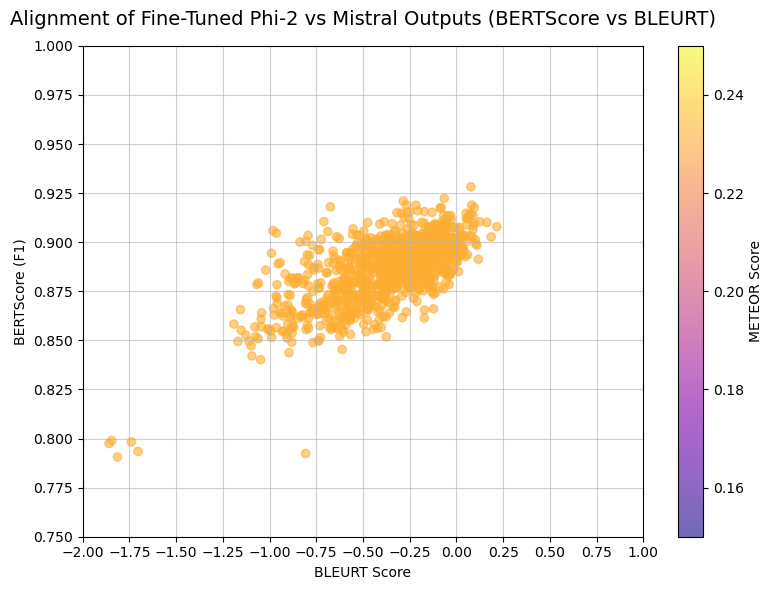

In [53]:
# Scatterplot: Alignment of Phi-2 vs Mistral Outputs
plt.figure(figsize=(8,6))

# Use values from the dataframe for plotting
plt.scatter(results_df['bleurt'], 
            results_df['bertscore'], 
            c=results_df['meteor'], 
            cmap="plasma", 
            alpha=0.6)

# Add a color bar for METEOR scores
plt.colorbar(label="METEOR Score")

# Plot settings
plt.title("Alignment of Fine-Tuned Phi-2 vs Mistral Outputs (BERTScore vs BLEURT)",
          fontsize=14,
          fontweight='medium',
          pad=15)
plt.xlabel("BLEURT Score")
plt.xticks(np.arange(-2.000, 1.001, 0.25))
plt.ylabel("BERTScore (F1)")
plt.yticks(np.arange(0.750, 1.001, 0.025))
plt.clim(0.150, 0.250)

plt.grid(True,
         alpha=0.6)
plt.tight_layout()
plt.savefig(img_path + '/fine-tuned_phi-2_vs_mistral_alignment.png')
plt.show()

##### Saving

In [2]:
# Save sample
eval_path = '../data/ready_for_phi-2/eval/'
if not os.path.exists(eval_path):
    os.makedirs(eval_path)

In [94]:
# Save results
results_df.to_csv(eval_path + "fine-tuned_phi2_vs_mistral_scores.csv", index=False)

**BLEURT is better, but still low. -- Stronger Semantic Alignment**
- Since BLEURT measures semantic similarity based on deep contextual embeddings, this suggests the fine-tuned Phi-2 is now much closer in meaning to Mistral’s output.
- The fact that the score is still negative means there's room for improvement, but it’s a big step forward.
  > Phi-2's behavior of trying to tell stories is now way less than usual. Out of our 1k rows of test, it was about 2 or 3 (that I saw).

**BERTScore -- Better Contextual Similarity**
- Phi-2’s outputs are now even more similar to Mistral’s outputs in terms of contextual word representations.
- Since BERTScore evaluates word embeddings rather than exact word matches, this indicates that Phi-2 is better capturing the meaning and phrasing of Mistral.

**METEOR better, but still low -- More Exact Matches & Better Paraphrasing**
- Phi-2 now has better word choice, phrasing, and synonym matches.
- Since METEOR gives extra weight to synonyms and paraphrases, this suggests Phi-2 is generating responses that more closely match Mistral’s structure

### Fine-tuned Model: Summary of Eval
Phi-2's semantic understanding of what needs to be done has improved. The fine-tuning process has led to better semantic alignment and contextual similarity, as shown by the improvements in BLEURT, BERTScore, and METEOR.

While Phi-2 now mirrors Mistral’s responses more effectively, there is still room for improvement. BLEURT is still negative, indicating that some fine-grained semantic details might be missing. Further refinements could help Phi-2 align even more closely with Mistral’s outputs.

This is great in a way that maybe an extra round of training with 1-2k more rows per training would get it on par with Mistral's. I have about 14k/2k of train/test I could use yet.